## MS gate modelling

### Numerical Integrals - First order Magnus expansion

In this notebook we present the code used for computing the first order coefficients $I_{m}^{n}$ of Eq. (A9) and the second order coefficients $J^n_{1,m}$, $J^n_{2,m}$ , $J^n_{3,m}$ of Eqs. (A15), (A16) for a costant laser pulse

In [1]:
import numpy as np
import scipy
from math import factorial
import scipy.integrate as integrate
from scipy.special import binom
from itertools import product
%matplotlib inline
import matplotlib.pyplot as plt

def plot_matrix(data):
    fig, ax = plt.subplots(figsize=(5,5))

    cm = ax.imshow(data, aspect='auto')

    ax.set_xlabel("n")
    ax.set_ylabel("m")

    plt.colorbar(cm)
    plt.show()


In [2]:
# Omega - Rabi Frequency
# tau_g - gate time
params = {"Omega": 0.5,
          "tau_g": 2 * np.pi
          }

In [3]:
def f(tau, params):
    Omega = params.get("Omega", 0.5)
    return Omega * (np.exp(1j * tau) - 1)


def g(tau, params):
    Omega = params.get("Omega", 0.5)
    return Omega**2 * (tau - np.sin(tau))


def matrix_element_D(alpha, m, n):
    # Matrix element of the displacement operator D(alpha)
    if m >= n:
        sum_k = np.sum([(-1)**k * binom(n, k) *
                       np.abs(alpha)**(2 * k) /
                       factorial(m - n + k)
                       for k in range(n+1)]
                       )
        m_element = (np.sqrt(factorial(m)/factorial(n)) *
                     alpha ** (m - n) *
                     np.exp(-np.abs(alpha)**2 / 2) *
                     sum_k
                     )

    else:
        sum_k = np.sum([(-1)**(n - k) * binom(n, k) *
                       np.abs(alpha)**(2 * (m - k)) /
                       factorial(m - k)
                       for k in range(m + 1)]
                       )
        m_element = (np.sqrt(factorial(m)/factorial(n)) *
                     alpha.conjugate() ** (n - m) *
                     np.exp(-np.abs(alpha)**2 / 2) *
                     sum_k
                     )

    return m_element


def integrand_Imn(tau, m, n, params):
    return np.exp(1j * g(tau, params)) * matrix_element_D(f(tau, params), m, n)


def I_mn(m, n, params):
    # coefficients I_mn from equation (A9)
    tau_g = params.get("tau_g", 2 * np.pi)

    def real_part(tau):
        return scipy.real(integrand_Imn(tau, m, n, params))

    def im_part(tau):
        return scipy.imag(integrand_Imn(tau, m, n, params))

    re_integral = integrate.quad(real_part, 0, tau_g)
    im_integral = integrate.quad(im_part, 0, tau_g)

    return 1j * (re_integral[0] + 1j*im_integral[0]) / 2



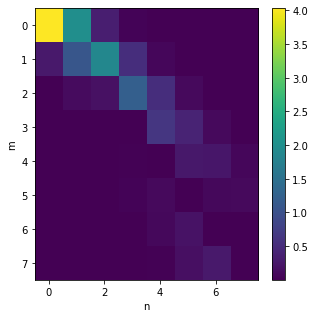

In [4]:
# Plot |I_mn|^2
grid_size = 8;
Ipp_array = np.array([np.abs(I_mn(m, n, params))**2
                     for m, n in product(range(grid_size), repeat=2)]).reshape((grid_size, grid_size))

plot_matrix(Ipp_array)

### Second Order Magnus Expansion

In [5]:
def integrand_J11(t1, t2, m, n, params):
    tau_g = params.get("tau_g", 2 * np.pi)
    J11 = (matrix_element_D(f(t2,params) - f(t1 - \
        tau_g,params),m,n)*np.exp(complex(0,-1)*np.conjugate(g(t1 - \
        tau_g,params)) + (np.conjugate(f(t1 - tau_g,params))*f(t2,params) - \
        np.conjugate(f(t2,params))*f(t1 - tau_g,params))/2. + \
        complex(0,1)*g(t2,params)))/4.
    return J11


def integrand_J12(t1, t2, m, n, params):
    tau_g = params.get("tau_g", 2 * np.pi)
    J12 = -(matrix_element_D(f(t1,params) - f(t2,params) + \
        f(tau_g,params),m,n)*np.exp(complex(0,-1)*np.conjugate(g(t2,params)) \
        + (np.conjugate(f(tau_g,params))*f(t2,params) - \
        np.conjugate(f(t2,params))*f(tau_g,params))/2. + \
        (-((-np.conjugate(f(t2,params)) + \
        np.conjugate(f(tau_g,params)))*f(t1,params)) + \
        np.conjugate(f(t1,params))*(-f(t2,params) + f(tau_g,params)))/2. + \
        complex(0,1)*g(t1,params) + complex(0,1)*g(tau_g,params)))/4. + \
        (matrix_element_D(-f(t1,params) + f(t2,params) + \
        f(tau_g,params),m,n)*np.exp(complex(0,-1)*np.conjugate(g(t1,params)) \
        + (np.conjugate(f(tau_g,params))*f(t1,params) - \
        np.conjugate(f(t1,params))*f(tau_g,params))/2. + \
        (-((-np.conjugate(f(t1,params)) + \
        np.conjugate(f(tau_g,params)))*f(t2,params)) + \
        np.conjugate(f(t2,params))*(-f(t1,params) + f(tau_g,params)))/2. + \
        complex(0,1)*g(t2,params) + complex(0,1)*g(tau_g,params)))/4.
    return J12

def J1(m, n, params):
    tau_g = params.get("tau_g", 2 * np.pi)

    def real_part_1(t1, t2):
        return scipy.real(integrand_J11(t1, t2, m, n, params))

    def im_part_1(t1, t2):
        return scipy.imag(integrand_J11(t1, t2, m, n, params))

    re_integral_1 = integrate.dblquad(real_part_1, 0, tau_g, lambda t2: 0, lambda t2: tau_g)
    im_integral_1 = integrate.dblquad(im_part_1, 0, tau_g, lambda t2: 0, lambda t2: tau_g)

    def real_part_2(t1, t2):
        return scipy.real(integrand_J12(t2, t1, m, n, params))

    def im_part_2(t1, t2):
        return scipy.imag(integrand_J12(t2, t1, m, n, params))

    re_integral_2 = integrate.dblquad(real_part_2, 0, tau_g, lambda t1: 0, lambda t1: t1)
    im_integral_2 = integrate.dblquad(im_part_2, 0, tau_g, lambda t1: 0, lambda t1: t1)

    return (re_integral_1[0] + re_integral_2[0])+ 1j*(im_integral_1[0] + im_integral_2[0])


def integrand_J21(t1, t2, m, n, params):
    tau_g = params.get("tau_g", 2 * np.pi)
    J21 = (matrix_element_D(f(t2,params) + f(t1 - tau_g,params),m,n)*np.exp((-(np.conjugate(f(t1 - tau_g,params))*f(t2,params)) + np.conjugate(f(t2,params))*f(t1 - tau_g,params) + complex(0,2)*(g(t2,params) - g(t1 - tau_g,params)))/2.))/4.
    return J21


def integrand_J22(t1, t2, m, n, params):
    tau_g = params.get("tau_g", 2 * np.pi)
    J22 = (matrix_element_D(f(t1,params) + f(t2,params) - f(tau_g,params),m,n)*(-np.exp(np.conjugate(f(t1,params))*f(t2,params) + complex(0,2)*g(t1,params)) + np.exp(np.conjugate(f(t2,params))*f(t1,params) + complex(0,2)*g(t2,params)))*np.exp((-(np.conjugate(f(t1,params))*f(t2,params)) + np.conjugate(f(tau_g,params))*(f(t1,params) + f(t2,params)) - np.conjugate(f(t1,params))*f(tau_g,params) - np.conjugate(f(t2,params))*(f(t1,params) + f(tau_g,params)) + complex(0,-2)*g(t1,params) + complex(0,-2)*g(t2,params) + complex(0,2)*g(tau_g,params))/2.))/4.
    return J22

def J2(m, n, params):
    tau_g = params.get("tau_g", 2 * np.pi)

    def real_part_1(t1, t2):
        return scipy.real(integrand_J21(t1, t2, m, n, params))

    def im_part_1(t1, t2):
        return scipy.imag(integrand_J21(t1, t2, m, n, params))

    re_integral_1 = integrate.dblquad(real_part_1, 0, tau_g, lambda t2: 0, lambda t2: tau_g)
    im_integral_1 = integrate.dblquad(im_part_1, 0, tau_g, lambda t2: 0, lambda t2: tau_g)


    def real_part_2(t1, t2):
        return scipy.real(integrand_J22(t2, t1, m, n, params))

    def im_part_2(t1, t2):
        return scipy.imag(integrand_J22(t2, t1, m, n, params))

    re_integral_2 = integrate.dblquad(real_part_2, 0, tau_g, lambda t2: 0, lambda t2: t2)
    im_integral_2 = integrate.dblquad(im_part_2, 0, tau_g, lambda t2: 0, lambda t2: t2)

    return (re_integral_1[0] + re_integral_2[0])+ 1j*(im_integral_1[0] + im_integral_2[0])


def integrand_J31(t1, t2, m, n, params):
    tau_g = params.get("tau_g", 2 * np.pi)
    J31 = ((matrix_element_D(f(t1,params) - f(t2,params),m,n) + matrix_element_D(-f(t1,params) + f(t2,params),m,n))*np.exp((-(np.conjugate(f(t2,params))*f(t1,params)) + np.conjugate(f(t1,params))*f(t2,params) + complex(0,2)*(g(t1,params) - g(t2,params)))/2.))/8.
    return J31


def integrand_J32(t1, t2, m, n, params):
    tau_g = params.get("tau_g", 2 * np.pi)
    J32 = ((matrix_element_D(f(t1,params) - f(t2,params),m,n) + matrix_element_D(-f(t1,params) + f(t2,params),m,n))*(np.exp(np.conjugate(f(t1,params))*f(t2,params) + complex(0,2)*g(t1,params)) - np.exp(np.conjugate(f(t2,params))*f(t1,params) + complex(0,2)*g(t2,params)))*np.exp((-(np.conjugate(f(t2,params))*f(t1,params)) - np.conjugate(f(t1,params))*f(t2,params) + complex(0,-2)*(g(t1,params) + g(t2,params)))/2.))/8.
    return J32


def J3(m, n, params):
    tau_g = params.get("tau_g", 2 * np.pi)

    def real_part_1(t1, t2):
        return scipy.real(integrand_J31(t1, t2, m, n, params))

    def im_part_1(t1, t2):
        return scipy.imag(integrand_J31(t1, t2, m, n, params))

    re_integral_1 = integrate.dblquad(real_part_1, 0, tau_g, lambda t2: 0, lambda t2: tau_g)
    im_integral_1 = integrate.dblquad(im_part_1, 0, tau_g, lambda t2: 0, lambda t2: tau_g)


    def real_part_2(t1, t2):
        return scipy.real(integrand_J32(t2, t1, m, n, params))

    def im_part_2(t1, t2):
        return scipy.imag(integrand_J32(t2, t1, m, n, params))

    re_integral_2 = integrate.dblquad(real_part_2, 0, tau_g, lambda t2: 0, lambda t2: t2)
    im_integral_2 = integrate.dblquad(im_part_2, 0, tau_g, lambda t2: 0, lambda t2: t2)

    return (re_integral_1[0] + re_integral_2[0])+ 1j*(im_integral_1[0] + im_integral_2[0])

In [6]:
n = 0
m = 0
print(J1(m, n, params))
print(J2(m, n, params))
print(J3(m, n, params))

(4.855481131590017+4.314263505507647j)
(2.469264932883705+3.771944688324039j)
(6.407585321181335+2.517437598983104j)
